# Tutorial Part 2: mapping multiple phases in a sample pixel-by-pixel

In the first tutorial, we saw how to find Friedel pairs and label them in a 3DXRD dataset. We also saw that using pencil-beam scanning, we not only get the correct orientation of diffraction vectors, but also the coordinates from which they arise from in the sample reference frame, allowing to reconstruct phase maps and get crystal orientation on a pixel basis.

In this second tutorial, we will see how to compute a 2D phase map in a complex sample featuring multiple phases. We saw in tutorial 001 that this is not necessarily straightforward, because significant overlap can occur between the hkl rings of different phases, creating ambiguity in assignement of diffraction peaks to a phase. This tutorial introduces a pixel-labelling strategy which allows to deal with such cases. 

We will assume that the crystallographic phases in the sample are known, and accurate description of their crystal structure are provided in dedicated cif files. This may not be the case in general. Crystal structures from cif files collected in an online database may have been measured at different P-T conditions, or on crystals of slighly different composition, resulting in biaises in the accurate 2-theta angle of diffraction rings. It is also possible that some or all of the phases in the sample are unknown, and need to be identified beforehand. Using 3DXRD spotty data, a possible strategy consists in plotting a high-resolution histogram in 2-theta, mimmicing a powder spectrum. This XRD profile can then be exported to powder XRD analysis softwares for Rietveld analysis. This part is not described here (but maybe one day in another tutorial?)

### Load packages

In [1]:
import os, sys, glob
import h5py
import pylab as pl
import numpy as np
import concurrent.futures, multiprocessing
from tqdm import tqdm

import ImageD11.sinograms.dataset
import ImageD11.columnfile
import ImageD11.parameters


from pf_3dxrd import utils, friedel_pairs, pixelmap, crystal_structure, peak_mapping

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

### Load data

First we need to load the peakfile with paired peaks, that we previously computed in the first tutorial. This file should end with "_pks_p.h5"

In [2]:
# First 
def load_data(dsname, parfile, detector = 'frelon'):
    
    # paths
    pksfile = os.path.join(data_dir, dsname+'_pks_p.h5')
    dsfile  = pksfile.replace('pks_p','ds')
    
    # load ds file and peak file
    ds = ImageD11.sinograms.dataset.load(dsfile)
    print(f'Loading data for dataset {ds.dsname}: \n==============================')    
    items = 'n_ystep,n_ostep,ymin,ymax,ystep,omin,omax,ostep'.split(',')
    vals  = [ds.shape[0], ds.shape[1], ds.ymin, ds.ymax, ds.ystep, ds.omin, ds.omax, ds.ostep]
    for i,j in zip(items, vals):
        print(f'{i}: {j:.1f}')
        
    print('==============================')
    
    
    cf = ImageD11.columnfile.columnfile(pksfile)
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    
    # update tth, etc. using Friedel pairs. 
    friedel_pairs.update_geometry_s3dxrd(cf, detector = detector, update_gvecs=True)

    
    print('\n loaded peakfile: \nnrows =', cf.nrows)
    utils.get_colf_size(cf)
    
    return cf, ds


In [3]:
# paths
data_dir = 'data'
dsname = 'SI3_DT360Z5480'
parfile='data/SI3.par'

# load data
cf, ds = load_data(dsname, parfile, detector='frelon')

Loading data for dataset SI3_DT360Z5480: 
n_ystep: 109.0
n_ostep: 450.0
ymin: -2.7
ymax: 2.7
ystep: 0.1
omin: 0.0
omax: 360.0
ostep: 0.8
Reading your columnfile in hdf format

 loaded peakfile: 
nrows = 2870942
Total size =  251.89 MB


We need to load crystal structures as well. We will use the CS class from crystal_structure.py introduced in the previous tutorial. We will only compute the 80 strongest peaks for each phase, to avoid saturating the 2-theta range with minor hkl peaks

CS: quartz, phase_id: 0, spg: P3221, spg_no: 154, lattice: [4.91325, 4.91325, 5.41206, 90.0, 90.0, 120.0]
Scatter(quartz with 2 atomic positions, 6 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -180.0
         max theta: 180.0
      min twotheta: 2
      max twotheta: 20
 ---X-Ray Settings---
 Waasmaier scattering factor: False
 ---Magnetic Settings---
   Mag. scattering: True
  Mag. form factor: True
         Polarised: False
      Polarisation: sp
       Pol. vector: (0,1,0)
 ---Resonant Settings---
   Azimuthal angle: 0
    Azimuthal ref.: (1,0,0)
               flm: (0,1,0)
  use e1e1 approx.: True

CS: magnetite, phase_id: 1, spg: Fd3m, spg_no: 227, lattice: [8.3965, 8.3965, 8.3965, 90.0, 90.0, 90.0]
Scatter(magnetite with 3 atom

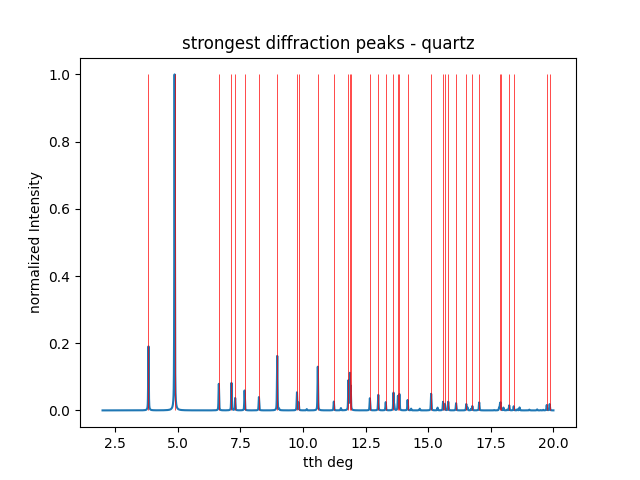

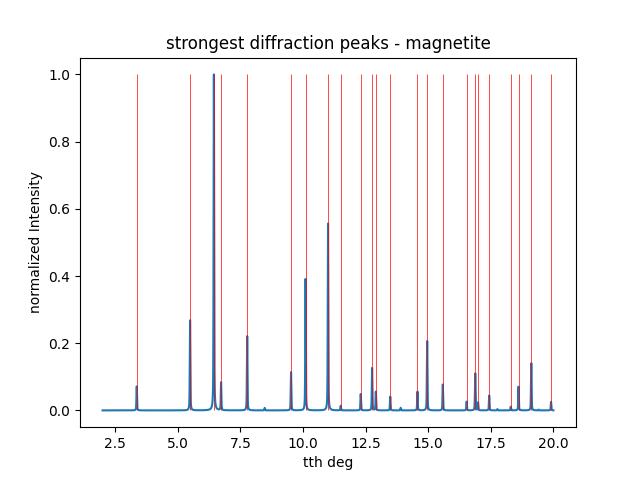

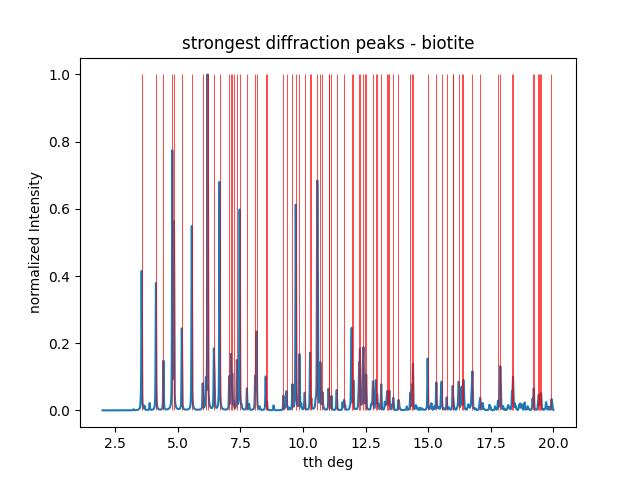

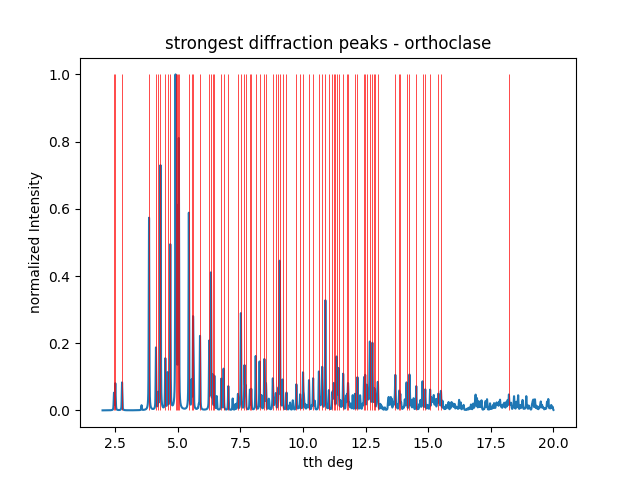

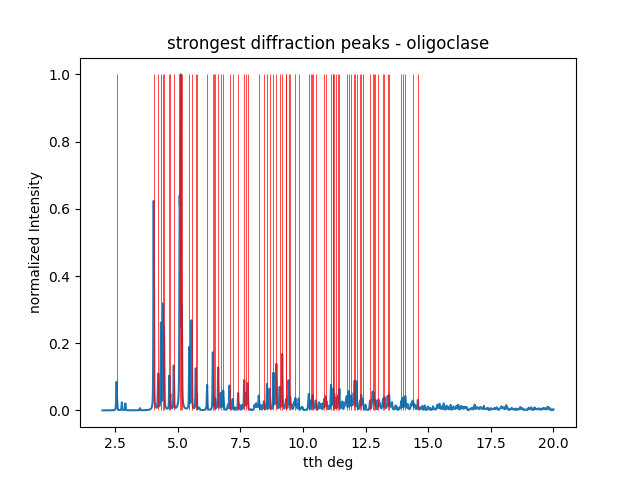

In [4]:
# load crystal structures and store them in a dictionnary
pnames = ['quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase']
phase_dict = {name: crystal_structure.load_CS_from_cif(cif_path = f'cif/{name}.cif', name=name, pid = i) for i,name in enumerate(pnames)}
pids = [cs.phase_id for cs in phase_dict.values()]


wl = cf.parameters.get('wavelength')

# compute 2-theta peaks for each phase
for cs in phase_dict.values():
    print(cs)
    cs.compute_powder_spec(wl, min_tth=2, max_tth=20, doplot=False)
    cs.find_strongest_peaks(Imin=0.01, Nmax=80, doplot=True)
 

### Assign peaks ot pixels

Using (xs,ys) coordinates in the sample reference frame, each peak can be assigned to a pixel on a 2D map, where the size of the grid is controlled by the step size of translations in the y-direction during scanning (ds.ystep). This is done using the function add_pixel_labels from the module peak_mapping.py. This module contains functions to do mapping operations between peaks in a peakfile, pixels on a 2D grid and grains in a grain list (once such a list has been computed).

In [5]:
# add pixel labeling to cf
peak_mapping.add_pixel_labels(cf, ds)

print(cf.titles)

['sc', 'fc', 'omega', 's_raw', 'f_raw', 'sum_intensity', 'spot3d_id', 'dty', 'fp_dist', 'fp_id', 'number_of_pixels', 'xl', 'yl', 'zl', 'tth', 'eta', 'gx', 'gy', 'gz', 'ds', 'tthc', 'dsc', 'xs', 'ys', 'r_dist', 'xi', 'yi', 'xyi']


Now we see three new columns xi, yi and xyi. xi and yi are the coordinate of the pixel to which each peak is assigned on the 2D map.
xyi is a unique index built using these two coordinates: xyi = xi + 10000.yi. This index is unique to each pixel as long as the map is less than 10000 pixels wide, which should normally be the case. It allows rapid search of pixels in a unique list indices instead of two, while preserving pixel coordinates information.

In [6]:
# have a look on a subset of xi, yi and xyi arrays
for col in ['xi','yi','xyi']:
    print(f'{col} : {cf.getcolumn(col)[120:130:2]}')

# xi and yi can be easily retrived from xyi:
print(f'xyi%10000:{cf.xyi[120:130:2]%10000}')
print(f'xyi//10000:{cf.xyi[120:130:2]//10000}')

xi : [38 46 47 47 48]
yi : [7 7 7 7 7]
xyi : [70038 70046 70047 70047 70048]
xyi%10000:[38 46 47 47 48]
xyi//10000:[7 7 7 7 7]


### Compute phase masks

A prerequisite for phase labeling is to compute phase masks, ie. boolean masks to select peaks potentially corresponding to a given phase. These masks are built using a 2-theta threshold selection around each hkl ring ofthe selected phase. We did it for quartz in the last tutorial. Here we will do it for all phases, using the function compute_phase_masks below. It will loop through every phase in the phase dictionary, compute a boolean mask array for this phase, and add it to a new dictionnary "masks". Two other masks are also computed for peaks "indexed" (assigned to at least one phase), and "notindexed" (not assigned to any phase).

In [7]:
def compute_phase_masks(cf, cs_list, tth_tol = 0.025, tth_max = 20, check_overlap=False, verbose=False, doplot=False):
    """ compute selection masks for all phases in cs_list """
    masks = {}
    # compute mask for all phases in phase_dict
    
    for cs in phase_dict.values():
        masks[cs.name] = utils.select_tth_rings(cf, cs.strong_peaks[0], tth_tol = tth_tol, tth_max = tth_max)
        if verbose:
            print(f'peak fraction {cs.name}: {np.count_nonzero(masks[cs.name])/cf.nrows:.4f}')  # prop of peaks assigned to each phase
        
    if check_overlap:    
        # check overlap between phases
        allphases = np.concatenate([masks[p] for p in phase_dict.keys()]).reshape(len(masks.keys()),len(masks[cs.name]))
        allphases = np.sum(allphases, axis=0)
        if verbose:
            print('overlap ', '%.4f' %(np.count_nonzero(allphases>1)/np.count_nonzero(allphases>=1)) )

        # add notindexed column to mask dict
        masks['notindexed'] = allphases == 0
        masks['indexed'] = allphases > 0
        
        if verbose:
            print('notIndexed', '%.4f' %(np.count_nonzero(masks['notindexed'])/len(masks['notindexed'])) )
            
            
    if doplot:
        colors = pl.cm.tab10(np.arange(len(cs_list)+1))
        
        fig = pl.figure(figsize=(10,5))
        fig.add_subplot(111)
        
        pl.plot(cf.tthc, cf.eta,',')
        for i,(m,cs) in enumerate( zip(masks.values(), cs_list) ):
            pl.plot(cf.tthc[m],cf.eta[m], ',', color = colors[i+1])
            pl.vlines(cs.strong_peaks[0], ymin=-100, ymax=100, colors = colors[i+1], label=cs.name)
        pl.legend(loc='upper right')
        pl.xlabel('2θ deg')
        pl.ylabel('eta deg')
    

    return masks

peak fraction quartz: 0.2591
peak fraction magnetite: 0.0201
peak fraction biotite: 0.1952
peak fraction orthoclase: 0.3639
peak fraction oligoclase: 0.4093
overlap  0.4831
notIndexed 0.2180
CPU times: user 3.32 s, sys: 211 ms, total: 3.53 s
Wall time: 3.51 s


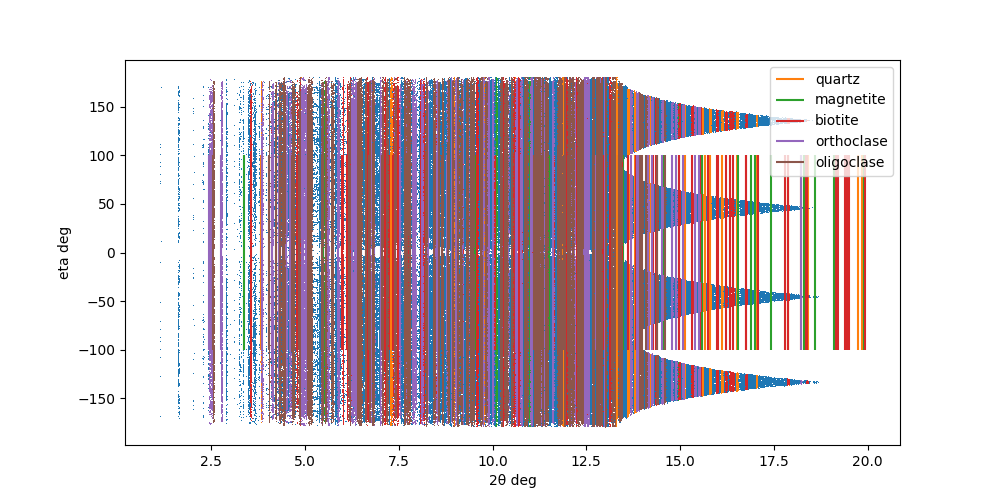

In [8]:
%%time
# create a boolean mask for each phase and store them in a new columnfile
mask_dict = compute_phase_masks(cf, phase_dict.values(), tth_tol = 0.025, tth_max = 20, check_overlap=True, verbose=True, doplot=True)
masks = ImageD11.columnfile.colfile_from_dict(mask_dict)

# add other useful columns to this columnfile: intensity and xyi index
lf = ImageD11.refinegrains.lf(cf.tthc, cf.eta)  # lorentz factor for intensity scaling
masks.addcolumn(cf.xyi.copy(), 'xyi')
masks.addcolumn(cf.sum_intensity.copy()*lf, 'sumI')
masks.sortby('xyi')

Peak selection looks quite messy at this point. There is large overlap, meaning that many peaks are selected multiple times by each phase mask. A significant proportion of peaks remains notindexed. This may correspond to minor phases not considered in the phase list, or diffraction rings not belonging to the N-strongest rings previously computed for each phase. This is not a big issue, as phase labeling can be done on a subset of the different phases, without needing all the peaks.


### Assign phase labels pixel-by-pixel
No we need to sort this mess. It is much easier to do it pixel-by pixel, for several reasons. First, the peak selection is reduced, with peaks only coming from a small pixel instead of the entire sample. Then, ambiguous situations, where multiple phases overlap, do not affect equally all regions of the sample. Overlaps are more prominent near grain boundaries than in grain centers, and are also more common between phases sharing similar crystal structures than between phases of completely different space groups. Thus, confidence in phase assignment can vary greatly between different regions of the map. Pixel-by-pixel processing allows to evaluate this confidence locally, and assign a label only to pixels for which a unique phase can be attributed with a reasonably high certainty. 

The function pixel_phase_match below returns the best phase match for a given pixel, as well as the list of peaks to keep within this pixel (ie, it excludes all peaks not selected by the best-matching phase). This function can be run independently over each pixel, allowing multiprocessing. For the SI3_DT360Z5480 dataset, it is not critical since it will run in a few seconds, but it becomes necessary for very large datasets with tens to hundreds millions of peaks. 

In [9]:
def pixel_phase_match(px, **kwargs):
    """ map phases pixel-by-pixel. Best-matching phase is the one gathering the highest total cumulated intensity over a pixel, 
    when peaks are selected using a certain 2-theta threshold arround each hkl ring of each phase
    
    output: 
    px : pixel xyi index
    pid : phase id on the pixel. -1 if notindexed
    Ci  : confidence index on the pixel, betwen 0 and 1. returns 0 if notindexed
    pksids: list of peak indices corresponding to the indexed phase -> used to update cf.phase_id
    
    Function written for parallel computation"""
    
    # extract keyword arguments
    pnames = kwargs['pnames']             # phase names
    pids   = kwargs['pids']               # phase ids   
    n      = kwargs['n_phases']           # number of phases
    minpks = kwargs['minpks']             # minimum nb of peaks to assign a phase ot a pixel
    min_Ci = kwargs['min_conf_index']     # minimum confidence index to assign a phase ot a pixel
    ks     = kwargs['px_kernel_size']     # size of peak selection around a pixel: single pixel or kernel selection

    
    # select peaks from px
    s = peak_mapping.pks_from_px(masks.xyi, px, kernel_size=ks)
    if len(s) == 0:
        return px, -1, 0, []
    
    
    # n peaks: if not enough peaks associated with a phase, return 'notindexed' and do not select any peak from this pixel
    npk = np.array([np.count_nonzero(masks.getcolumn(p)[s]) for p in pnames])
    if max(npk) < minpks:
        return px, -1, 0, [] 
    
    # if enough peaks: return phase with highest integrated intensity (sum of intensity of all peaks)
    sum_I = np.array([sum(masks.getcolumn(p)[s] * masks.sumI[s]) for p in pnames])
    sum_I_all_phases =  sum(masks.sumI[s])
    sum_I_norm = sum_I / sum_I_all_phases   # ratio of the two above
    
    # Confidence index in phase assignment
    if n > 1:
        Ci = n/(n-1) * sum_I_norm[np.argmax(sum_I_norm)]  - 1/(n-1) # criterion to assess quality of phase indexing   
    else:
        Ci = 1
    
    pid = pids[np.argmax(sum_I_norm)]  # phase_id of phase with highest score on this pixel

    if Ci < min_Ci:  #  threshold. do not index pixels below min_Ci
        pid = -1
        
    if pid == -1:  # set conf_indx to zero if best matching phase is 'notIndexed'
        return px, -1, 0, []
    else:
        # peak selection (to update cf.phase_id column)
        pks = masks.getcolumn(pnames[pids.index(pid)])[s]            # bool array to select only peaks from the indexed phase
        pksids = s[pks]                                      # pks index of selected peaks 
        
        return px, pid, Ci, pksids


In [10]:
# First we need to sort cf by xyi. This is necessary to quickly select peaks by pixel index. 
cf.sortby('xyi')

# Initialize new column 'phase_id', which will contain the phase labels. phase_id = -1 corresponds to notindexed
cf.addcolumn(np.full(cf.nrows,-1, dtype=int), 'phase_id')

There are several parameters to set up for phase labeling. They are input as keyword arguments passed to the pixel_phase_match function.
- pnames: list of phase names
- pids: list of phase ids. Unique integer value corresponding to each phase and used to label the phase map. These phase ids have already been defined when loading crystal structures, and are accessible typing cs.phase_id
- n_phases: number of phases in the map
- minpks: minimum number of peaks in a pixel. If the best-matching phase collects less than minpks over a pixel, this one will remain notindexed
- min_conf_ind: For each pixel, a confidence index Ci varying between 0 and 1 is computed, which gives information on how reliable is phase assignment. Pixel falling below this value will remain notindexed. When set to 0, all pixels are selected. 
- px_kernel_size: Allows selection of peaks in a moving kernel around each pixel. When set to 1, only single pixels are selected. 


pnames, pids and n_phases are computed directly from phase_dict. We need to find a good starting guess for minpks. We will set min_conf_ind to 0 first, to keep all peaks whatever the confidence index. We will run the function first setting px_kernel_size to 1.

Text(0, 0.5, 'pixel count')

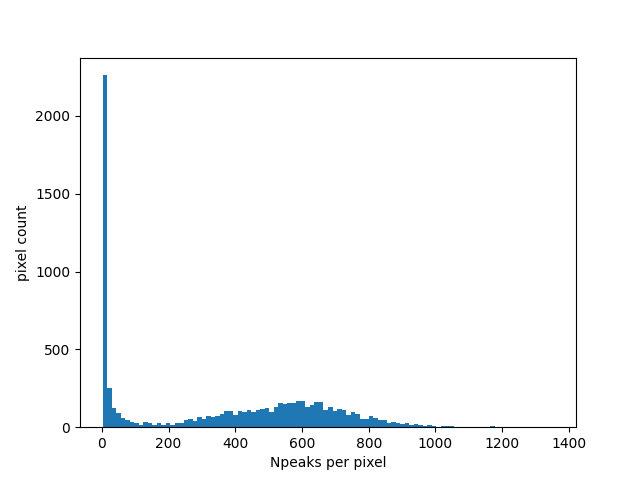

In [11]:
# get an idea of how many peaks there are per-pixel, to have a good initial guess of a value for minpks
_, cnts = np.unique(cf.xyi, return_counts=True)
pl.figure()
pl.hist(cnts,100);
pl.xlabel('Npeaks per pixel')
pl.ylabel('pixel count')


There are clearly two populations of pixels with <150 and >150 peaks. The group of pixels with low peak count probably corresponds to pixels outside the sample, containing dodgy friedel pairs for which relocalization in the sample is inaccurate. A minpks cutoff of 150 seems to be a good guess. However, we also need to account for the fact that only a fraction of peaks per pixel will be selected be each phase, so we need to reduce a bit this value to avoid being too restrictive in the peak selection. We will start at 100.

In [12]:
# sorted indices in cf.xyi: needs to be run beforehand
xyi_uniqs, inds = peak_mapping.sorted_xyi_inds(cf, is_sorted=False)  # all indices

# It is possible to run the labeling function on a subset of pixels. Just uncomment and the lines below and define the filter you want
xyi_sub = np.array(xyi_uniqs)  
#sel = np.all([xyi_sub//10000 > 100, xyi_sub//10000 < 360, xyi_sub%10000 < 250], axis=0)   # mask for subset selection
#xyi_sub = xyi_sub[sel]

# keywork arguments to pass to phase matching function
kwargs = {'pnames': list(phase_dict.keys()),
          'pids'  : [cs.phase_id for cs in phase_dict.values()],
          'n_phases' : len(phase_dict.keys()),
          'minpks': 100,
          'min_conf_index': 0.0,
          'px_kernel_size': 1 }

print(f'Number of pixels to process: {len(xyi_sub)}')

# func wrapper: wrap args and kwargs
def func_wrapper(px):
    return pixel_phase_match(px, **kwargs)


# parralel computation
ncpu = len(os.sched_getaffinity( os.getpid() ))
with concurrent.futures.ProcessPoolExecutor( max_workers=max(ncpu-1,1),
                                            mp_context=multiprocessing.get_context('fork') ) as pool:
        
    results = {} 

    for r in tqdm(pool.map( func_wrapper, xyi_sub, chunksize=500) ):
        results[r[0]] = r[1:]

Number of pixels to process: 7928


7928it [00:00, 39189.86it/s]


In [13]:
%%time
# check fraction of peaks assigned to each phase and total fraction of peaks labeled in cf
pnames = [p for p in phase_dict]
pids = [cs.phase_id for cs in phase_dict.values()]

print('fraction of peaks labeled \n----------') 
for (pname,pid) in zip(pnames, pids):
    print(f'{pname}:{np.count_nonzero(cf.phase_id == pid) / cf.nrows : .3f}' )
    
print(f'----------\ntotal labeled:{np.count_nonzero(cf.phase_id != -1) / cf.nrows : .3f} \n----------')

fraction of peaks labeled 
----------
quartz: 0.000
magnetite: 0.000
biotite: 0.000
orthoclase: 0.000
oligoclase: 0.000
----------
total labeled: 0.000 
----------
CPU times: user 9.42 ms, sys: 2.36 ms, total: 11.8 ms
Wall time: 9.93 ms


### Visualizing outputs in a Pixelmap

The pixel labeling function has run in parallel and outputs have been stored in a 'results' dictionary. Now we need to unpack these outputs. We introduce here a new class "Pixelmap" from the module pixelmap.py, which aims at storing and visualizing data on a 2D pixel grid. This class has many functionalities, which we will explore in this tutorial and the following ones. From now on, it is the main object on which we will work. 

First, we need to initialize the pixelmap (xmap). For this, we need to define a grid and add phases.

In [14]:
# xmap grid
xb = yb = np.arange(len(ds.ybinedges))  # grid bins, defined from ds
xmap = pixelmap.Pixelmap(xb, yb, h5name = os.path.join(data_dir, ds.dsname+'_xmap.h5'))  # path for saving
xmap.grid.pixel_size = ds.ystep
xmap.grid.pixel_unit = 'mm'
    
# xmap phases
for phasename, cs in phase_dict.items():
    xmap.phases.add_phase(phasename, cs)

print(xmap,'\n-------')
print(xmap.grid,'\n-------')
print(xmap.phases)

for p in xmap.phases.pnames: 
    print(xmap.phases.get(p))

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id'], 
 grains: 0 
-------
grid: size: (110, 110), pixel size: 0.05 mm 
-------
phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase']
CS: notIndexed, phase_id: -1, spg: None, spg_no: None, lattice: []
CS: quartz, phase_id: 0, spg: P3221, spg_no: 154, lattice: [4.91325, 4.91325, 5.41206, 90.0, 90.0, 120.0]
CS: magnetite, phase_id: 1, spg: Fd3m, spg_no: 227, lattice: [8.3965, 8.3965, 8.3965, 90.0, 90.0, 90.0]
CS: biotite, phase_id: 2, spg: C12/m1, spg_no: 12, lattice: [5.355, 9.251, 10.246, 90.0, 100.15, 90.0]
CS: orthoclase, phase_id: 3, spg: C1-11, spg_no: 12, lattice: [8.589, 13.013, 7.197, 90.0, 116.02, 90.0]
CS: oligoclase, phase_id: 4, spg: C-1, spg_no: 2, lattice: [8.154, 12.823, 7.139, 94.06, 116.5, 88.59]


xmap is defined on a grid of 110 by 110 pixels, with a pixel size of 50 µm, and has the phases in phase_dict assigned. Grid information are stored in xmap.grid, and phases in xmap.phases. For each phase, a CS object is attached, accessible at xmap.phases.phase_name or using the method xmap.phases.get('phase_name'). 

A number of columns have been defined during initialization, namely pixel index, phase_id and grain_id, all with the same shape (N,1) where N = len(xb).len(yb). For now, phase_id and grain_id only contain -1 values, meaning no phase or grains have been labeled. 

In [15]:
print(f'{xmap.xyi=:} {xmap.xyi.shape:}')
print(f'{xmap.phase_id=:} {xmap.phase_id.shape:}')
print(f'{xmap.grain_id=:} {xmap.grain_id.shape:}')


xmap.xyi=[      0       1       2 ... 1090107 1090108 1090109] (12100,)
xmap.phase_id=[-1 -1 -1 ... -1 -1 -1] (12100,)
xmap.grain_id=[-1 -1 -1 ... -1 -1 -1] (12100,)


Now we want to update the phase_id column and add other columns from the result dict. This is done with the block of code below. This block updates at the same time the phase_id labels in the columnfile, which we had previously initialized. After running this code, we have two new columns 'Npks' and 'Ci' in xmap, containing respectively the number of peaks and the confidence index Ci for each pixel.

In [18]:
# initialize new data columns
xmap.add_data(np.full(xmap.xyi.shape, 0, dtype=np.uint16), 'Npks')
xmap.add_data(np.full(xmap.xyi.shape, 0, dtype=np.float64), 'Ci')

# loop through results, updare xmap and phase label in peakfile
for i,px in enumerate(tqdm(results)):
    indpx = np.argwhere(xmap.xyi == px)
    pks = results[px][2]
    if len(pks) > 0:
        xmap.Npks[indpx] = len(pks)
        xmap.Ci[indpx] = results[px][1]
        xmap.phase_id[indpx] = results[px][0]
        cf.phase_id[pks] = results[px][0]

print(xmap)  

100%|██████████| 7928/7928 [00:00<00:00, 97763.35it/s]

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'Ci'], 
 grains: 0


Now we can plot these data. 

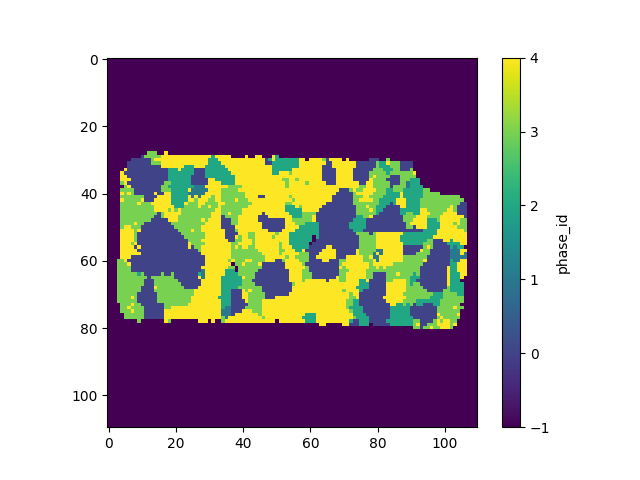

In [19]:
nx, ny = xmap.grid.nx, xmap.grid.ny

pl.figure()
pl.imshow(xmap.phase_id.reshape(nx,ny))
pl.colorbar(label='phase_id')

There are also built-in methods to quickly make nice plots

In [20]:
xmap.plot?

Signature:
xmap.plot(
    dname,
    save=False,
    hide_cbar=False,
    autoscale=True,
    percentile_cut=[2, 98],
    smooth=False,
    mf_size=1,
    out=False,
    **kwargs,
)
Docstring:
Make a pcolormesh plot for a selecte ddata column

Args:
--------
dname (str) : name of data array. data in self.dname must be a single array (shape (N,1))
save (bool) : save plot (default is False)
hide_cbar (bool) : hide colorbar from plot (delault is False)
smooth (bool) : apply median filter for smoothing plot
mf_size (int) : size of median filter kernel for smoothing. default is 1 
out (bool) : return figure as output (default is False)
autoscale (bool): automatically adjust color scale to distribution for each strain / steess component (default is True)
percentile_cut ([low,up]): percentile thresholds to cut distribution (for autoscale)
kwargs (dict) : keyword arguments passed to matplotlib
File:      ~/Friedel_Pairs_DEMO/custom_3DXRD_module/pixelmap.py
Type:      method

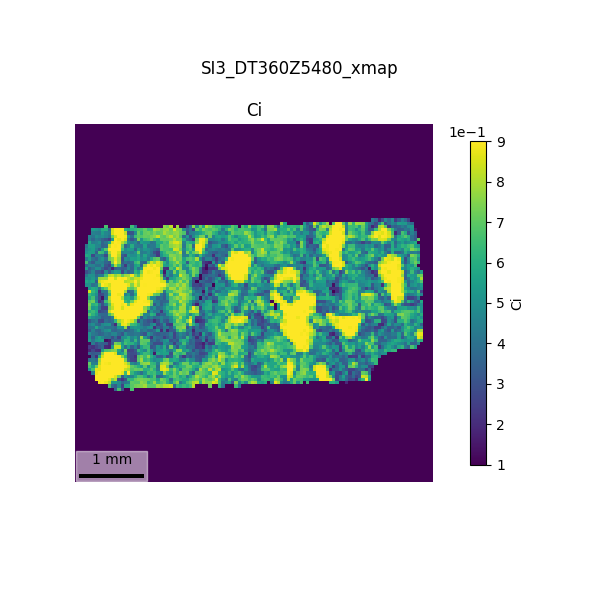

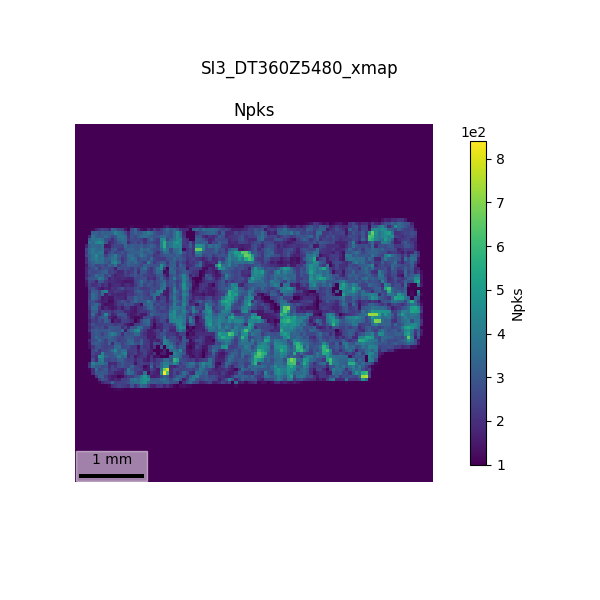

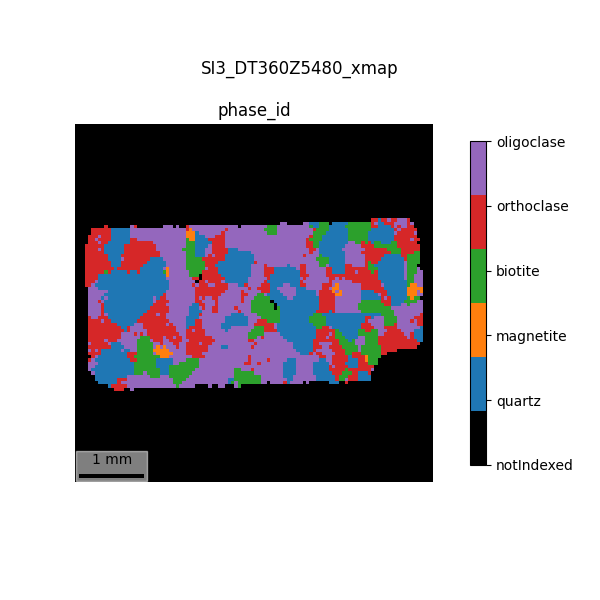

In [22]:
# make some plots : phase_id, Ci, Npks. 
# Warning: passing keyword arguments can result in some conflicts with built-in parameters,
# especially if autoscale is set to True and you try to pass scaling parameters like 'vmin' or 'vmax'

kw1 = {"cmap":'viridis', 'vmin':0.1, 'vmax':0.9}
kw2 = {"cmap":'viridis', 'vmin':100}

colors = ((0,0,0),) + pl.matplotlib.cm.tab10.colors
cmap = pl.matplotlib.colors.ListedColormap( colors[:len(xmap.phases.pnames)] )
kw3 = {"cmap": cmap}

save=False

xmap.plot('Ci', autoscale=False, save=save, **kw1)
xmap.plot('Npks', autoscale=False, save=save, **kw2)
xmap.plot('phase_id', autoscale=False, save=save, **kw3)

The map is almost complete, but looks a bit noisy. To improve this we can use a kernel selection instead of a single pixel selection. The idea is to label each pixel taking into account diffraction data arising from surrounding pixels in a kernel centered on this pixel. This will result to some degree of smoothing, similar to applying a median filter. Set px_kernel_size  = 3 (3x3 pixel selection) and run the labeling function again to see the difference. Don't forget to increase the minpks threshold! We are here selecting peaks over a 9-pixel region, so expect ~9 times more peaks in selection. You can also play with the min_conf_ind threshold, to keep only the most reliable part of the map labeled.

Once you are satifsied with your map save it to hdf format. Don't forget to save the peakfile as well, since it has also been updated with phase labels.  

In [23]:
# filter notindexed peaks and save 
cf.filter(cf.phase_id != -1)

# save new cf
outname = os.path.join(data_dir,ds.dsname+'_pks_p_flt.h5')  # add 'flt' to filename -> new peakfile with only labeled peaks 
utils.colf_to_hdf(cf, outname, save_mode = 'minimal')

# save xmap
xmap.save_to_hdf5()

Pixelmap saved to: data/SI3_DT360Z5480_xmap.h5


Text(0.5, 0.98, 'peak selection by pixel – sample SI3_DT360Z5480')

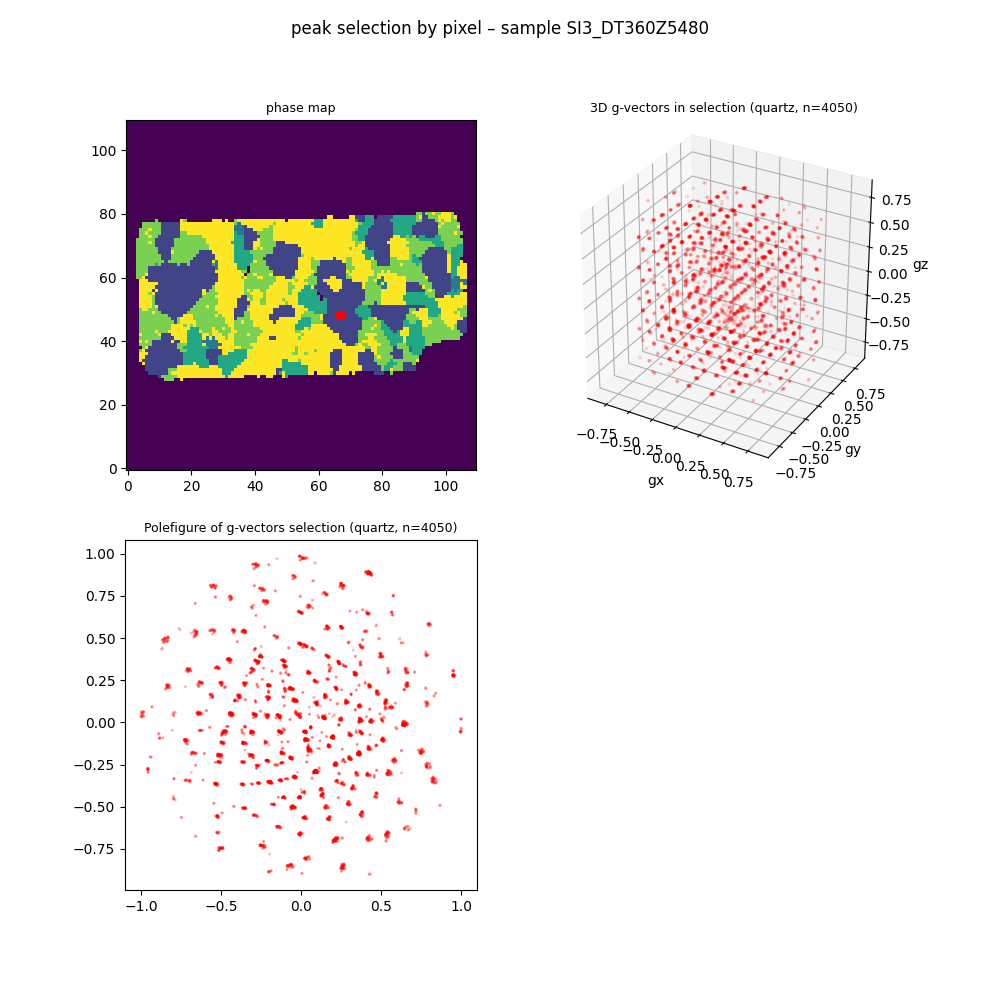

In [25]:
# plot subset of g-vectors from a 3x3 pixel group

colors = [(1, 0, 0, 0),(1, 0, 0, 1)]  # Red and transparent
binary_cmap = pl.matplotlib.colors.LinearSegmentedColormap.from_list('binary_red', colors, N=2)


xy0 = 480067   # pixel index
pid = xmap.phase_id[xmap.xyi.tolist().index(xy0)]   # corresponding phase id
pname = xmap.phases.pnames[xmap.phases.pids.index(pid)]

# mask on xmap.xyi array
mx = np.any([xmap.xyi == xy0, xmap.xyi == xy0-1, xmap.xyi == xy0+1,
             xmap.xyi == xy0-10001, xmap.xyi == xy0 - 10000, xmap.xyi == xy0 - 9999,
             xmap.xyi == xy0+9999, xmap.xyi == xy0+10000, xmap.xyi == xy0+10001], axis=0)

# find corresponding peaks in cf -> mcf mask
xyi_uniq, inds = peak_mapping.sorted_xyi_inds(cf, is_sorted=True)
pks = peak_mapping.pks_from_px(cf.xyi, xy0, kernel_size=3)
mcf = np.full(cf.nrows, False)
mcf[pks] = True
mcf = np.all([mcf, cf.phase_id == pid], axis=0)



# make plots with phase labels and selected g-vectors
fig = pl.figure(figsize=(10,10))
fig.add_subplot(221, aspect='equal')

pl.pcolormesh(xb,yb,xmap.phase_id.reshape(nx,ny), cmap='viridis')
pl.pcolormesh(xb,yb,mx.reshape(nx,ny), cmap=binary_cmap)
pl.title("phase map", fontsize=9)

ax = fig.add_subplot(222, aspect='equal', projection='3d')
ax.scatter(cf.gx[mcf], cf.gy[mcf], cf.gz[mcf], s=np.log(cf.sum_intensity[mcf])/3, color='r', alpha=.1)
ax.set_title(f'3D g-vectors in selection ({pname}, n={np.count_nonzero(mcf)})', fontsize=9)
ax.set_xlabel('gx')
ax.set_ylabel('gy')
ax.set_zlabel('gz')

ax2 = fig.add_subplot(223)
n = (cf.ds[mcf] + abs(cf.gz[mcf]))
X = cf.gx[mcf] * np.sign(cf.gz[mcf])/n
Y = cf.gy[mcf] * np.sign(cf.gz[mcf])/n
ax2.scatter(X,Y,s=np.log(cf.sum_intensity[mcf])/5, c='r', alpha=.2)
ax2.set_title(f'Polefigure of g-vectors selection ({pname}, n={np.count_nonzero(mcf)})', fontsize=9)

fig.suptitle(f'peak selection by pixel – sample {ds.dsname}')